#### 基本設置 + 設cuda

In [11]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 16
num_classes = 4
learning_rate = 0.002
num_epochs = 25

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### 讀取資料集

In [12]:
import torchvision.datasets as dset

# 定义数据转换
transform = transforms.Compose([
    transforms.Resize((480, 256)),  # 将图像调整为指定大小
    transforms.ToTensor(),           # 将图像转换为张量
])

# 加載圖像數據集，並只考慮指定的資料夾
dataset = dset.ImageFolder(root='./dataset/train', transform=transform)

# 獲取相關信息
print(dataset.classes)  # 根據分的文件夾的名字來確定類別
print(dataset.class_to_idx)  # 按順序為這些類別定義索引為 0, 1, ...
print(len(dataset))  # 返回數據集的大小

print(dataset[0][0].size())  # 返回第一張圖片的大小

['boat', 'boat+fish', 'boat+whale', 'dolphin', 'dolphin+boat', 'dolphin+fish', 'dolphin+whale', 'fish', 'fish+whale', 'whale']
{'boat': 0, 'boat+fish': 1, 'boat+whale': 2, 'dolphin': 3, 'dolphin+boat': 4, 'dolphin+fish': 5, 'dolphin+whale': 6, 'fish': 7, 'fish+whale': 8, 'whale': 9}
223
torch.Size([3, 480, 256])


用自定義dataset的方式改變label (因為要多標籤分類)

In [13]:
from torch.utils.data import Dataset
dict_for_label = {
                    'boat':[1,0,0,0], 'dolphin':[0,1,0,0], 'fish':[0,0,1,0], 'whale':[0,0,0,1],
                    'boat+fish':[1,0,1,0], 'boat+whale':[1,0,0,1],
                    'dolphin+boat':[1,1,0,0], 'dolphin+whale':[0,1,0,1], 'dolphin+fish':[0,1,1,0],
                    'fish+whale':[0,0,1,1]
                  }
# 自定義資料集，基於 ImageFolder 並支持多標籤
class MultiLabelImageDataset(Dataset):
    def __init__(self, image_folder, label_mapping, transform=None):
        # 使用 ImageFolder 來獲取圖片和單標籤
        self.image_folder = dset.ImageFolder(image_folder, transform=transform)
        
        # 依照圖片標籤名稱來對應多標籤
        self.label_mapping = label_mapping  # 字典對應表

    def __len__(self):
        return len(self.image_folder)

    def __getitem__(self, idx):
        # 獲取圖片及其對應的單一標籤（由 ImageFolder 生成）
        img, class_idx = self.image_folder[idx]
        
        # 使用 ImageFolder 的 class_to_idx 來獲取標籤名稱
        label_name = self.image_folder.classes[class_idx]

        # 根據 label_name 查詢對應的 one-hot 編碼
        one_hot_label = torch.tensor(self.label_mapping[label_name], dtype=torch.float32)
        
        return img, one_hot_label

In [14]:
from torch.utils.data import DataLoader
# 使用自定義的多標籤資料集
dataset = MultiLabelImageDataset(image_folder='dataset_v3/train', label_mapping=dict_for_label, transform=transform)

# 使用 DataLoader 加載資料
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# 測試資料加載
for images, labels in dataloader:
    print(images.shape)  # 輸出: (batch_size, channels, height, width)
    print(labels.shape)  # 輸出: (batch_size, num_classes) -> multi-label one-hot encoded labels
    print(labels[0])  # 輸出: 第一張圖片的標籤
    print(images[0].size())  # 輸出: 第一張圖片的大小
    break

torch.Size([32, 3, 480, 256])
torch.Size([32, 4])
tensor([0., 0., 0., 1.])
torch.Size([3, 480, 256])


In [15]:
from torch.utils.data import DataLoader

# 加載圖像數據集，並只考慮指定的資料夾
train_dataset = MultiLabelImageDataset(image_folder='dataset_v3/train', label_mapping=dict_for_label, transform=transform)
test_dataset = MultiLabelImageDataset(image_folder='dataset_v3/test', label_mapping=dict_for_label, transform=transform)

# 创建 DataLoader 对象
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(len(train_loader))
print(len(test_loader))

11
4


#### 創立model

In [38]:
# # Create CNN Model
# class CNN_Model(nn.Module):
#     def __init__(self):
#         super(CNN_Model, self).__init__()
#         # Convolution , input_shape=(3,480,256)
#         self.layer1 = self.conv_module(3, 8, 5, 1) #output_shape=(8,238,126)
#         self.layer2 = self.conv_twice(8, 14, 3, 1) #output_shape=(14,118,62)
#         self.layer3 = self.conv_twice(14, 44, 3, 1) #output_shape=(44,58,30)
#         self.layer4 = self.conv_twice(44, 20, 3, 1) #output_shape=(20,28,14)
#         self.layer5 = self.conv_twice(20, 8, 5, 1) #output_shape=(8,12,5)
#         # # Fully connected 1
#         self.fc1 = nn.Linear(8*12*5, 4) 
        
#     def forward(self, x):
#         # Convolutions
#         out = self.layer1(x)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.layer5(out)
#         # Resize
#         out = out.view(out.size(0), -1)
#         # Linear function (readout)
#         out = self.fc1(out)
#         return out
    
#     def conv_module(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         "By giving the convolutional parameters, the function will return a convolutional module"
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
#             nn.ReLU(),
#             nn.BatchNorm2d(out_channels),
#             nn.MaxPool2d(kernel_size=2)
#         )
#     def conv_twice(self, in_channels, out_channels, kernel_size, stride, padding=0):
#         "By giving the convolutional parameters, the function will return a double convolutional module"
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),    # expand the channels
#             nn.ReLU(),
#             nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
#             nn.ReLU(),
#             nn.BatchNorm2d(out_channels),
#             nn.MaxPool2d(kernel_size=2)
#         )

In [5]:
import torch.nn as nn
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        # Convolution , input_shape=(3,480,256)
        self.layer1 = self.conv_module_for_5x5(3, 8, 3, 1) #output_shape=(8,238,126)
        self.layer2 = self.conv_twice(8, 14, 3, 1) #output_shape=(14,118,62)
        self.layer3 = self.conv_twice(14, 44, 3, 1) #output_shape=(44,58,30)
        self.layer4 = self.conv_twice(44, 20, 3, 1) #output_shape=(20,28,14)
        self.layer5 = self.conv_twice_for_5x5(20, 8, 3, 1) #output_shape=(8,12,5)
        # # Fully connected 1
        self.fc1 = nn.Linear(8*12*5, 4) 
        
    def forward(self, x):
        # Convolutions
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        # Resize
        out = out.view(out.size(0), -1)
        # Linear function (readout)
        out = self.fc1(out)
        return out
    
    def conv_module(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_module_for_5x5(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_twice(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a double convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),    # expand the channels
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )
    def conv_twice_for_5x5(self, in_channels, out_channels, kernel_size, stride, padding=0):
        "By giving the convolutional parameters, the function will return a double convolutional module"
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=padding),    # expand the channels
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2)
        )

In [40]:
import torchinfo
import torchinfo

model = CNN_Model()
print(f"Model's structure:\n {torchinfo.summary(model)}")

Model's structure:
Layer (type:depth-idx)                   Param #
CNN_Model                                --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       224
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       584
│    └─ReLU: 2-4                         --
│    └─BatchNorm2d: 2-5                  16
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-7                       126
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       1,778
│    └─ReLU: 2-10                        --
│    └─BatchNorm2d: 2-11                 28
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-13                      660
│    └─ReLU: 2-14                        --
│    └─Conv2d: 2-15                      17,468
│    └─ReLU: 2-16                        --
│    └─BatchNorm2d: 2-17                 

#### 訓練模型

In [41]:
import time
# Move model to "device".
model = model.to(device)
# File name.
modelSaveName = "MyModel_v3.h5"
# Create an optimizer.
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)
# Create a loss function
lossFunc = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss

bestTrainAcc = 1000
for epoch in range(1, num_epochs+1):
  start_time = time.time()  # 計算每個epoch開始的時間
  # Training mode.
  model.train()
  train_loss = 0.0
  for iter, (input, target) in enumerate(train_loader):
    # Move data to "device".
    input = input.to(device)
    target = target.to(device)

    # Clear optimizer gradients.
    optimizer.zero_grad()
    
    # Forward pass.
    output = model(input)
      
    # Compute the loss.
    loss=lossFunc(output, target)
    # Loss backward propagation.
    loss.backward()
    # Update all learnable parameters.
    optimizer.step()
    # update training loss
    train_loss += loss.item()

  # statistics
  # 計算每個樣本的平均損失
  train_loss = train_loss / len(train_loader)
  end_time = time.time()  # 計算每個epoch結束的時間
  epoch_time = end_time - start_time  # 計算每個epoch所花的時間
  print("Epoch:{}/{}, Time:{:.2f} seconds, Train Loss: {:.4f}".format(epoch, num_epochs, epoch_time, train_loss))

  # 存檔
  if epoch % 5 == 0 and bestTrainAcc > train_loss:
    bestTrainAcc = train_loss
    torch.save(model.state_dict(), modelSaveName, _use_new_zipfile_serialization=False)
    print('Model saved to %s' % modelSaveName)

Epoch:1/25, Time:4.36 seconds, Train Loss: 0.5971
Epoch:2/25, Time:3.81 seconds, Train Loss: 0.4142
Epoch:3/25, Time:3.77 seconds, Train Loss: 0.3611
Epoch:4/25, Time:3.86 seconds, Train Loss: 0.3324
Epoch:5/25, Time:4.00 seconds, Train Loss: 0.2419
Model saved to MyModel_v3.h5
Epoch:6/25, Time:3.99 seconds, Train Loss: 0.2616
Epoch:7/25, Time:3.84 seconds, Train Loss: 0.2158
Epoch:8/25, Time:3.82 seconds, Train Loss: 0.1787
Epoch:9/25, Time:4.11 seconds, Train Loss: 0.1643
Epoch:10/25, Time:3.83 seconds, Train Loss: 0.1330
Model saved to MyModel_v3.h5
Epoch:11/25, Time:3.88 seconds, Train Loss: 0.1133
Epoch:12/25, Time:3.77 seconds, Train Loss: 0.1105
Epoch:13/25, Time:3.87 seconds, Train Loss: 0.1033
Epoch:14/25, Time:3.84 seconds, Train Loss: 0.0863
Epoch:15/25, Time:3.83 seconds, Train Loss: 0.0678
Model saved to MyModel_v3.h5
Epoch:16/25, Time:4.10 seconds, Train Loss: 0.0585
Epoch:17/25, Time:3.82 seconds, Train Loss: 0.0430
Epoch:18/25, Time:3.84 seconds, Train Loss: 0.0340
Epoc

測試模型

In [9]:
import torch
model = CNN_Model()
model.load_state_dict(torch.load('MyModel_Remove5x5_v3.pt'))

<All keys matched successfully>

In [16]:
correct = 0
total = 0
# 新增這邊記錄真實跟預測值
pred_list = []
label_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        
        predicted_prob = torch.sigmoid(outputs)
        
        # 將每個類別的預測概率與閾值 0.5 比較，大於 0.5 的表示預測該類別存在 (標記為 1)
        predicted = (predicted_prob > 0.5).int()

        # 計算每個樣本的預測是否與真實標籤完全相同
        correct += (predicted == labels).all(dim=1).sum().item()
        total += labels.size(0)

        pred_list.extend(predicted.cpu().numpy())
        label_list.extend(labels.cpu().numpy())

In [17]:
from sklearn.metrics import accuracy_score
import numpy as np

# change to numpy array
pred_list = np.array(pred_list)
label_list = np.array(label_list)

print(f'Subset Accuracy of the network on the {total} test images: {accuracy_score(label_list, pred_list)*100} %')

def Accuracy(y_pred, y_true):
    count = 0
    for i in range(y_true.shape[0]):  # 幾個樣本
        p = sum(np.logical_and(y_pred[i], y_true[i]))
        q = sum(np.logical_or(y_pred[i], y_true[i]))
        count += p / q
    return count / y_true.shape[0]

print(f'Accuracy of the network on the {total} test images: {Accuracy(pred_list, label_list)*100} %')

Subset Accuracy of the network on the 59 test images: 88.13559322033898 %
Accuracy of the network on the 59 test images: 89.83050847457628 %


In [18]:
# precision, recall, f1-score
from sklearn.metrics import precision_score, recall_score, f1_score

print(f'Precision: {precision_score(label_list, pred_list, average="samples")}')
print(f'Recall: {recall_score(label_list, pred_list, average="samples")}')
print(f'F1-score: {f1_score(label_list, pred_list, average="samples")}')

Precision: 0.9067796610169492
Recall: 0.9067796610169492
F1-score: 0.903954802259887


d:\ancode\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


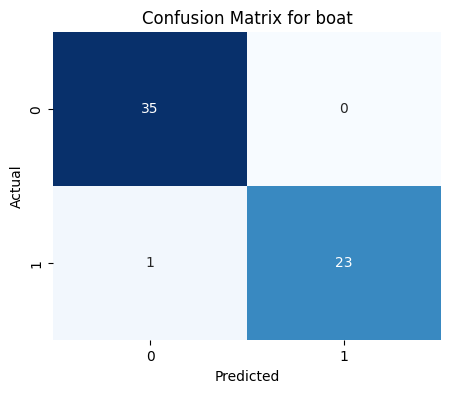

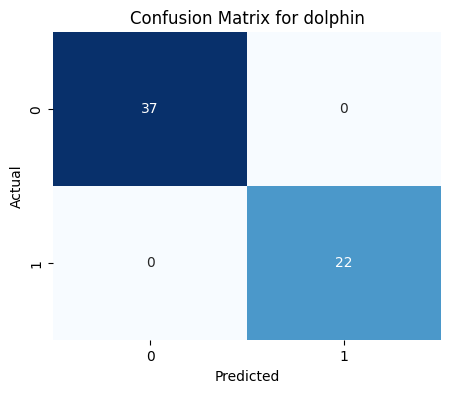

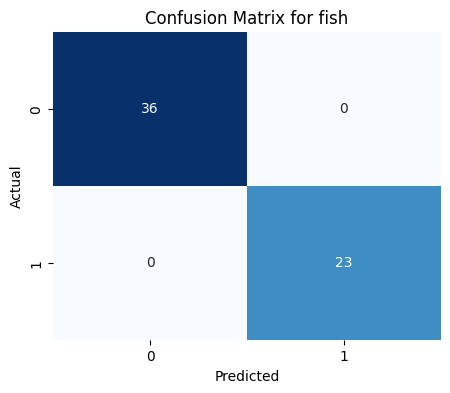

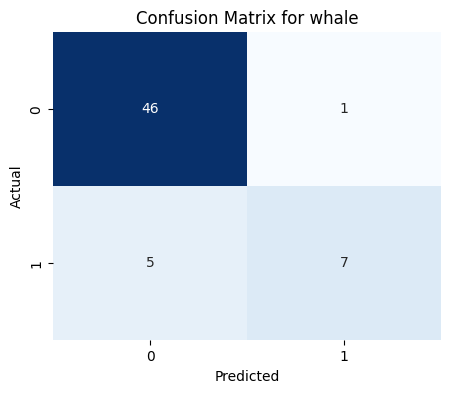

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

pred_list = np.array(pred_list)
label_list = np.array(label_list)

for i , class_name in enumerate(dict_for_label.keys()):
    if i >= num_classes:
        break

    cm = confusion_matrix(label_list[:, i], pred_list[:, i])
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {class_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


計算hamming loss

In [20]:
from sklearn.metrics import hamming_loss

# 計算 Hamming Loss
hloss = hamming_loss(label_list, pred_list)
print(f"Hamming Loss: {hloss}")

Hamming Loss: 0.029661016949152543


測試那些有海豚的船聲

In [ ]:
model = CNN_Model()
model.load_state_dict(torch.load('MyModel_v3_91percent.pt'))

In [ ]:
from PIL import Image
imgPaths = ['./dataset_v2/test/boat/denoise_20201017_221700.png',
           './dataset_v2/test/boat/denoise_20201017_203800.png',
           './dataset_v2/test/boat/denoise_20201017_123457.png',
           './dataset_v2/test/boat/denoise_20201016_233700.png',
           './dataset_v2/test/boat/denoise_20201016_120407.png'
           ]

for num, imgPath in enumerate(imgPaths):
    img = Image.open(imgPath).convert('RGB')
    img = transform(img)    # apply the transform to the image

    img = img.unsqueeze(0)  # add a batch dimension [batch, channels, width, height]

    with torch.no_grad():
        print("Predicting image %d: %s" %(num ,imgPath.split('/')[-1]))
        # calculate outputs by running images through the network
        outputs = model(img)
        # the class with the highest energy is what we choose as prediction
        predicted_prob = torch.sigmoid(outputs)
        
        # 將每個類別的預測概率與閾值 0.5 比較，大於 0.5 的表示預測該類別存在 (標記為 1)
        predicted = (predicted_prob > 0.5).int()
        # find key by value in dictionary
        print(f'Predicted class: {list(dict_for_label.keys())[list(dict_for_label.values()).index(predicted.tolist()[0])]}')

Predicting image 0: denoise_20201017_221700.png
Predicted class: boat
Predicting image 1: denoise_20201017_203800.png
Predicted class: boat
Predicting image 2: denoise_20201017_123457.png
Predicted class: boat
Predicting image 3: denoise_20201016_233700.png
Predicted class: boat
Predicting image 4: denoise_20201016_120407.png
Predicted class: boat
